This flocking example is based on the following colab notebook:  
https://github.com/google/jax-md/blob/main/notebooks/flocking.ipynb

In [1]:
import jax
from IPython.display import Image as DisplayImage

from evojax import Trainer
from evojax.policy import MLPPolicy
from evojax.algo import PGPE
from evojax.task.flocking import FlockingTask
from evojax.util import create_logger

In [2]:
# Let's create a directory to save logs and models.
log_dir = './log'
logger = create_logger(name='EvoJAX', log_dir=log_dir)
logger.info('Welcome to the tutorial on Task creation!')

logger.info('Jax backend: {}'.format(jax.local_devices()))
!nvidia-smi --query-gpu=name --format=csv,noheader

EvoJAX: 2022-03-24 04:18:55,409 [INFO] Welcome to the tutorial on Task creation!
absl: 2022-03-24 04:18:55,416 [INFO] Starting the local TPU driver.
absl: 2022-03-24 04:18:55,417 [INFO] Unable to initialize backend 'tpu_driver': Not found: Unable to find driver in registry given worker: local://
absl: 2022-03-24 04:18:55,596 [INFO] Unable to initialize backend 'tpu': Invalid argument: TpuPlatform is not available.
EvoJAX: 2022-03-24 04:18:55,596 [INFO] Jax backend: [GpuDevice(id=0, process_index=0)]


NVIDIA A100-SXM4-40GB


## Compare Reward Functions
In flocking.py, the reward function can be selected at init.  

- When 0  
Normal reward function.

- When 1  
The reward is made to be larger in the future.

Let's look at the difference between two reward functions.

### Normal reward function

In [16]:
seed = 42
neighbor_num = 5

rollout_key = jax.random.PRNGKey(seed=seed)

reset_key, rollout_key = jax.random.split(rollout_key, 2)
reset_key = reset_key[None, :] 

train_task = FlockingTask(150)
test_task = FlockingTask(150)

policy = MLPPolicy(
    input_dim=neighbor_num*3,
    hidden_dims=[60, 60],
    output_dim=1,
    logger=logger,
)

solver = PGPE(
    pop_size=64,
    param_size=policy.num_params,
    optimizer='adam',
    center_learning_rate=0.05,
    seed=seed,
)

trainer = Trainer(
    policy=policy,
    solver=solver,
    train_task=train_task,
    test_task=test_task,
    max_iter=150,
    log_interval=10,
    test_interval=30,
    n_repeats=5,
    n_evaluations=10,
    seed=seed,
    log_dir=log_dir,
    logger=logger,
)
_ = trainer.run()

EvoJAX: 2022-03-24 04:34:08,535 [INFO] MLPPolicy.num_params = 4681
EvoJAX: 2022-03-24 04:34:08,608 [INFO] Start to train for 150 iterations.
EvoJAX: 2022-03-24 04:34:10,303 [INFO] Iter=10, size=64, max=-123.7782, avg=-138.0884, min=-169.3285, std=7.5780
EvoJAX: 2022-03-24 04:34:10,776 [INFO] Iter=20, size=64, max=-118.0680, avg=-128.5788, min=-152.9263, std=7.0288
EvoJAX: 2022-03-24 04:34:11,246 [INFO] Iter=30, size=64, max=-122.1357, avg=-130.4212, min=-147.6441, std=4.7727
EvoJAX: 2022-03-24 04:34:12,275 [INFO] [TEST] Iter=30, #tests=10, max=-104.2781 avg=-130.1164, min=-166.0425, std=16.5553
EvoJAX: 2022-03-24 04:34:12,772 [INFO] Iter=40, size=64, max=-116.6864, avg=-130.0655, min=-140.9319, std=4.8480
EvoJAX: 2022-03-24 04:34:13,266 [INFO] Iter=50, size=64, max=-120.1276, avg=-128.3874, min=-135.6488, std=3.4330
EvoJAX: 2022-03-24 04:34:13,729 [INFO] Iter=60, size=64, max=-116.6938, avg=-124.6629, min=-134.2303, std=4.2751
EvoJAX: 2022-03-24 04:34:13,775 [INFO] [TEST] Iter=60, #tes

reward=[-100.92389]


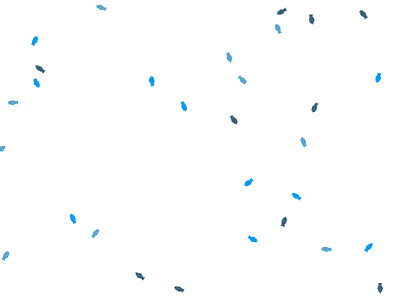

In [17]:
def render(task, algo, policy):

    state_list = []

    task_reset_fn = jax.jit(task.reset)
    policy_reset_fn = jax.jit(policy.reset)
    step_fn = jax.jit(task.step)
    act_fn = jax.jit(policy.get_actions)

    params = algo.best_params[None, :]
    task_s = task_reset_fn(jax.random.PRNGKey(seed=seed)[None, :])
    policy_s = policy_reset_fn(task_s)

    images = [FlockingTask.render(task_s, 0)]
    done = False
    step = 0
    reward = 0
    while not done:
        act, policy_s = act_fn(task_s, params, policy_s)
        task_s, r, done = step_fn(task_s, act)
        if step % 10 == 0:
            state_list.append(task_s.state[0])
        step += 1
        reward = reward + r
        images.append(FlockingTask.render(task_s, 0))
    state_list.append(task_s.state[0])
    print('reward={}'.format(reward))
    return images, state_list


def save_images_as_gif(images, file_name):
  images[0].save(file_name,
                save_all=True, append_images=images[1:], optimize=False, duration=40, loop=0)

imgs, state_list1 = render(test_task, solver, policy)
save_images_as_gif(imgs, 'flocking.gif')
DisplayImage('flocking.gif', format='png')

### larger future rewards

In [18]:
seed = 42
neighbor_num = 5

rollout_key = jax.random.PRNGKey(seed=seed)

reset_key, rollout_key = jax.random.split(rollout_key, 2)
reset_key = reset_key[None, :] 

train_task = FlockingTask(150, 1)
test_task = FlockingTask(150, 1)

policy = MLPPolicy(
    input_dim=neighbor_num*3,
    hidden_dims=[60, 60],
    output_dim=1,
    logger=logger,
)

solver = PGPE(
    pop_size=64,
    param_size=policy.num_params,
    optimizer='adam',
    center_learning_rate=0.05,
    seed=seed,
)

trainer = Trainer(
    policy=policy,
    solver=solver,
    train_task=train_task,
    test_task=test_task,
    max_iter=150,
    log_interval=10,
    test_interval=30,
    n_repeats=5,
    n_evaluations=10,
    seed=seed,
    log_dir=log_dir,
    logger=logger,
)
_ = trainer.run()

EvoJAX: 2022-03-24 04:37:17,122 [INFO] MLPPolicy.num_params = 4681
EvoJAX: 2022-03-24 04:37:17,198 [INFO] Start to train for 150 iterations.
EvoJAX: 2022-03-24 04:37:18,843 [INFO] Iter=10, size=64, max=-36.0305, avg=-43.4749, min=-52.5915, std=3.8598
EvoJAX: 2022-03-24 04:37:19,307 [INFO] Iter=20, size=64, max=-33.6511, avg=-38.5775, min=-44.6881, std=2.4351
EvoJAX: 2022-03-24 04:37:19,777 [INFO] Iter=30, size=64, max=-33.2717, avg=-38.0736, min=-49.5482, std=3.9560
EvoJAX: 2022-03-24 04:37:20,920 [INFO] [TEST] Iter=30, #tests=10, max=-30.4645 avg=-33.5102, min=-41.8219, std=3.4830
EvoJAX: 2022-03-24 04:37:21,409 [INFO] Iter=40, size=64, max=-32.6695, avg=-35.6453, min=-40.1368, std=1.5279
EvoJAX: 2022-03-24 04:37:21,894 [INFO] Iter=50, size=64, max=-32.3484, avg=-35.4193, min=-40.6308, std=1.7719
EvoJAX: 2022-03-24 04:37:22,360 [INFO] Iter=60, size=64, max=-30.7894, avg=-33.9590, min=-37.8375, std=1.4536
EvoJAX: 2022-03-24 04:37:22,415 [INFO] [TEST] Iter=60, #tests=10, max=-32.7239 av

reward=[-27.357628]


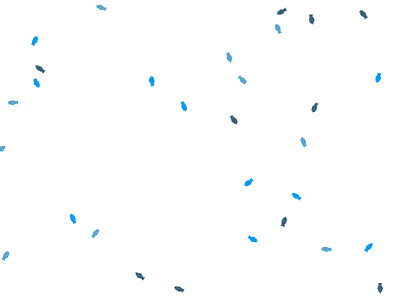

In [19]:
def render(task, algo, policy):

    state_list = []

    task_reset_fn = jax.jit(task.reset)
    policy_reset_fn = jax.jit(policy.reset)
    step_fn = jax.jit(task.step)
    act_fn = jax.jit(policy.get_actions)

    params = algo.best_params[None, :]
    task_s = task_reset_fn(jax.random.PRNGKey(seed=seed)[None, :])
    policy_s = policy_reset_fn(task_s)

    images = [FlockingTask.render(task_s, 0)]
    done = False
    step = 0
    reward = 0
    while not done:
        act, policy_s = act_fn(task_s, params, policy_s)
        task_s, r, done = step_fn(task_s, act)
        if step % 10 == 0:
            state_list.append(task_s.state[0])
        step += 1
        reward = reward + r
        images.append(FlockingTask.render(task_s, 0))
    state_list.append(task_s.state[0])
    print('reward={}'.format(reward))
    return images, state_list


def save_images_as_gif(images, file_name):
  images[0].save(file_name,
                save_all=True, append_images=images[1:], optimize=False, duration=40, loop=0)

imgs, state_list2 = render(test_task, solver, policy)
save_images_as_gif(imgs, 'flocking2.gif')
DisplayImage('flocking2.gif', format='png')

It can be seen the larger the future reward, eventually the more equally aligned the fishes become.

To be sure, let's output two box-plot diagram as well.

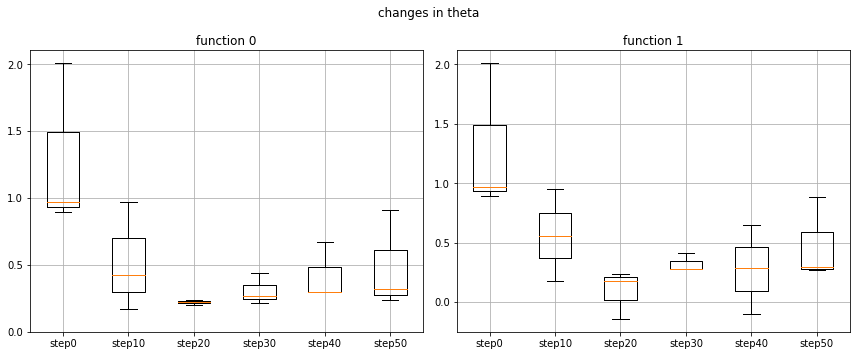

In [27]:
import matplotlib.pyplot as plt

points1 = (state_list1[0][2], state_list1[1][2], state_list1[2][2], state_list1[3][2], state_list1[4][2], state_list1[5][2])
points2 = (state_list2[0][2], state_list2[1][2], state_list2[2][2], state_list2[3][2], state_list2[4][2], state_list2[5][2])

fig, ax = plt.subplots(1, 2, tight_layout=True, figsize=(12, 5))

ax[0].boxplot(points1) 
ax[0].set_xticklabels(['step0', 'step10', 'step20', 'step30', 'step40', 'step50'])

ax[1].boxplot(points2)
ax[1].set_xticklabels(['step0', 'step10', 'step20', 'step30', 'step40', 'step50'])

ax[0].set_title('function 0')
ax[1].set_title('function 1')

ax[0].set_yticks([0, 0.5, 1.0, 1.5, 2.0])
ax[1].set_yticks([0, 0.5, 1.0, 1.5, 2.0])

ax[0].grid()
ax[1].grid()

plt.savefig('boxplot_theta.png')
plt.suptitle('changes in theta')
plt.savefig('boxplot_theta.png')
plt.show()

Function0 showed a rapid alignment to increase rewards.